In [1]:
import torch
from torch import nn
torch.cuda.is_available()
from torchgeo.samplers import RandomGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
import os
from torchgeo.datasets import RasterDataset
import pylab as plt
import torchvision
import torch.nn.functional as F

/mnt/work/python/dkottke/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformations import (
    ComposeDouble,
    AlbuSeg2d,
    FunctionWrapperDouble,
    normalize_01,
    create_dense_target,
)
from unet import UNet
from trainer import Trainer

In [3]:
class BengaluruDataset(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """

    filename_glob = "*.tif"
    

class BengaluruDatasetLabels(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """
    is_image = False
    filename_glob = "*.tif"

In [4]:
# base path of the dataset
TRAIN_PATH = os.path.join("Data", "Train")
TEST_PATH = os.path.join("Data", "Test")

tr_labels = lambda x: x[:,0,:,:].long()

class TransBengaluruLabels(nn.Module):
    """."""

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        # Batch
        if inputs["mask"].ndim == 4:
            inputs["mask"] = inputs["mask"][:,0,:,:].long()
        # Sample
        else:
            inputs["mask"] = inputs["mask"][0,:,:].long()
        
        return inputs

ds = BengaluruDataset(os.path.join(TRAIN_PATH, "Images"))
la = BengaluruDatasetLabels(os.path.join(TRAIN_PATH, "Labels"), transforms=TransBengaluruLabels())

train_ds = ds & la

ds2 = BengaluruDataset(os.path.join(TEST_PATH, "Images"))
la2 = BengaluruDatasetLabels(os.path.join(TEST_PATH, "Labels"), transforms=TransBengaluruLabels())

test_ds = ds2 & la2

Converting BengaluruDatasetLabels resolution from 1.200444240953174 to 1.2004442409532352


In [5]:
DATASET_SIZE = 512
BATCH_SIZE = 128
IMG_SIZE = 128


train_sampler = RandomGeoSampler(train_ds, size=IMG_SIZE, length=DATASET_SIZE)
test_sampler = RandomGeoSampler(test_ds, size=IMG_SIZE, length=DATASET_SIZE)

train_dl = DataLoader(train_ds, BATCH_SIZE, sampler=train_sampler, collate_fn=stack_samples)
test_dl  = DataLoader(test_ds, BATCH_SIZE, sampler=test_sampler, collate_fn=stack_samples)

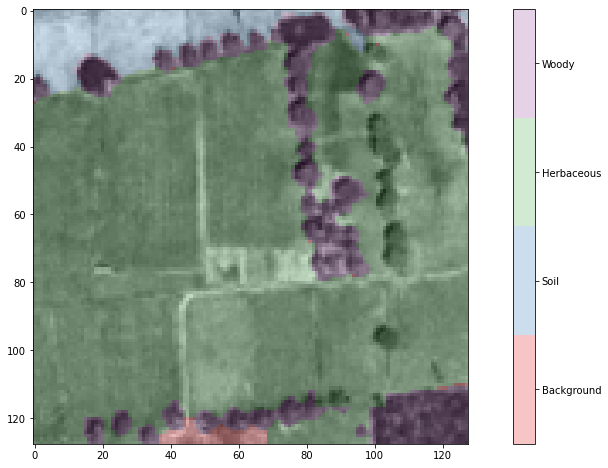

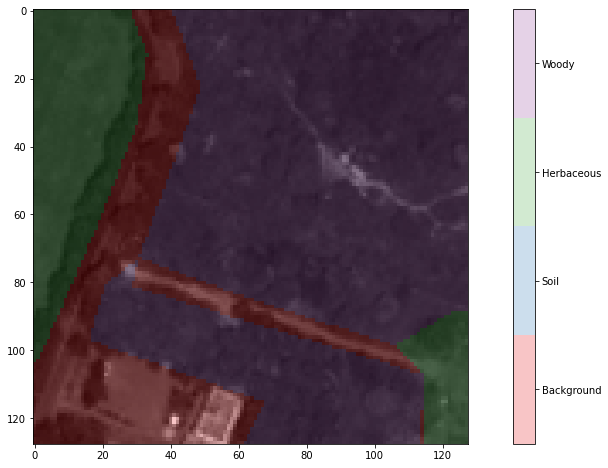

In [6]:
def visualize(image, mask):
    """PLot images in one row."""
    fig = plt.figure(figsize=(16, 8))
    #plt.imshow(image[0].transpose(0,2), vmin=0, vmax=1)
    image /= image.numpy().max()
    plt.imshow(image, cmap='gray')
    #plt.imshow(image[0])
    if mask.max()>0:
        plt.imshow(mask/9, alpha=0.25, vmin=0, vmax=1, cmap='Set1', interpolation='nearest')
        
    cb = plt.colorbar(cmap='Dark2', ticks=np.linspace(0.5/9, 3.5/9, 4), boundaries=np.linspace(0,4/9,5))
    cb.set_ticklabels(['Background', 'Soil', 'Herbaceous', 'Woody'])
    plt.show()

for dl in [train_dl, test_dl]:
    for sample in dl:
        idx = 0
        image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
        target = sample["mask"][idx, :, :]

        visualize(image, target)
        break

In [7]:
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model
model = UNet(
    in_channels=5,
    out_channels=4,
    n_blocks=2,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=train_dl,
    validation_dataloader=test_dl,
    lr_scheduler=None,
    epochs=2,
    epoch=0,
    notebook=False,
)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Training: (loss 1.4215): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                                                                      
Training: (loss nan): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                                                                   
Progress: 100%|██████████| 2/2 [00:12<00:00,  6.39s/it]              
